# AVA Dataset

In [14]:
epochs = 3
data_name = 'animal'
num_classes = 2
from models import Classifier as Model
weight_path = 'weights/{}_{}.pt'.format(data_name, Model.__name__, num_classes)
weight_path

'weights/animal_Classifier.pt'

In [15]:
from data import BinaryAVA
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
import torch

train_dataset = BinaryAVA('data/AVA_dataset/aesthetics_image_lists/{}_train.jpgl'.format(data_name), 
              transform=transforms.Compose([
                  transforms.Resize(256),
                  transforms.CenterCrop(256),
                  transforms.ToTensor()
              ]))

test_dataset = BinaryAVA('data/AVA_dataset/aesthetics_image_lists/{}_test.jpgl'.format(data_name), 
              transform=transforms.Compose([
                  transforms.Resize(256),
                  transforms.CenterCrop(256),
                  transforms.ToTensor()
              ]))

### Toggle cell below for sample debugging

In [16]:
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=128, shuffle=True, num_workers=2)
    
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=128, shuffle=True, num_workers=2)

In [17]:
an_item = test_dataset[1]
an_img = an_item[0]
a_label = an_item[1]

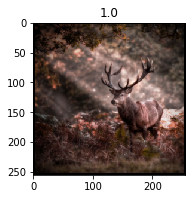

In [18]:
plt.subplot(1,2,1)
plt.title(a_label)
plt.imshow(an_img.numpy().transpose((1,2,0)))

# Model

In [19]:
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

### Load model

In [20]:
import os

if os.path.exists(weight_path):
    model.load_state_dict(torch.load(weight_path))

In [21]:
len(train_loader.dataset), len(test_loader.dataset)

(494, 496)

In [22]:
from tqdm import tqdm

In [23]:
def train(epoch):
    model.train()
    model.to(device)
    total_loss = 0
    total_acc = 0
    for data, labels in tqdm(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        batch_size = labels.shape[0]
        labels = labels.float()        
        foo = torch.ones(batch_size).float() - labels
        bar = labels
        one_hot_labels = torch.cat([foo.view(-1, 1), bar.view(-1,1)], dim=1)
        one_hot_labels = one_hot_labels.to(device)
        
        preds = model(data)
        
        label_preds = torch.argmax(preds, dim=1)
        acc = torch.eq(label_preds.cpu(), labels.long()).sum()
        total_acc += acc.item()
        
        loss = F.binary_cross_entropy(preds, one_hot_labels, reduction='sum')
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_loader.dataset)
    avg_acc = total_acc / len(test_loader.dataset)
    return avg_loss, avg_acc
    
def test(epoch):
    model.eval()
    model.to(device)
    total_loss = 0
    total_acc = 0
    for data, labels in tqdm(test_loader):
        data = data.to(device)
        batch_size = labels.shape[0]
        labels = labels.float()
        foo = (torch.ones(batch_size).float() - labels)
        bar = labels
        one_hot_labels = torch.cat([foo.view(-1, 1), bar.view(-1, 1)], dim=1)
        one_hot_labels = one_hot_labels.to(device)
        
        preds = model(data)
        
        label_preds = torch.argmax(preds, dim=1)
        
        acc = torch.eq(label_preds.cpu(), labels.long()).sum()
        total_acc += acc.item()
        
        
        loss = F.binary_cross_entropy(preds, one_hot_labels, reduction='sum')
        total_loss += loss.item()
        
    avg_loss = total_loss / len(test_loader.dataset)
    avg_acc = total_acc / len(test_loader.dataset)
    return avg_loss, avg_acc

In [24]:
%%time
train_losses = []
test_losses = []

train_accs = []
test_accs = []
for e in range(epochs):
    train_loss, train_acc = train(e)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    test_loss, test_acc = test(e)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print("Epoch {} Train {:.2f}, {:.2f} (loss, acc) Test Loss {:.2f}, {:.2f} (loss,acc)"
          .format(e, train_loss, train_acc, test_loss, test_acc))
    


100%|██████████| 4/4 [00:08<00:00,  2.32s/it]

100%|██████████| 4/4 [00:08<00:00,  2.47s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0 Train 1.39, 0.53 (loss, acc) Test Loss 1.39, 0.50 (loss,acc)



100%|██████████| 4/4 [00:08<00:00,  2.33s/it]

100%|██████████| 4/4 [00:08<00:00,  2.34s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1 Train 1.34, 0.60 (loss, acc) Test Loss 1.39, 0.50 (loss,acc)



100%|██████████| 4/4 [00:08<00:00,  2.32s/it]

100%|██████████| 4/4 [00:08<00:00,  2.35s/it]


Epoch 2 Train 1.31, 0.63 (loss, acc) Test Loss 1.39, 0.50 (loss,acc)
CPU times: user 2.74 s, sys: 1.54 s, total: 4.28 s
Wall time: 51.4 s


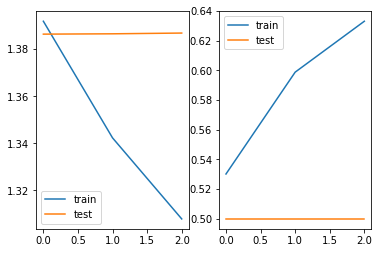

In [25]:
plt.subplot(1,2,1)
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.subplot(1,2,2)

plt.plot(train_accs, label='train')
plt.plot(test_accs, label='test')
plt.legend()

### Save model

In [26]:
torch.save(model.state_dict(), weight_path)